In [11]:
import numpy as np
import pickle
import torch
import math
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from mutect3 import data, validation, plotting, spectrum, threshold

# we need to explicitly import in order for unpickling to work
from mutect3.tensors import Datum, SiteMetadata, Mutect2Data 
from mutect3.networks import ReadSetClassifier, PriorAdjustedReadSetClassifier

%matplotlib inline

In [2]:
NUM_READ_FEATURES = 11  #size of each read's feature vector from M2 annotation
NUM_INFO_FEATURES = 9   # size of each variant's info field tensor (3 components for HEC, one each for HAPDOM, HAPCOMP)
                        # and 5 for ref bases STR info
REF_DOWNSAMPLE = 10 # choose this many ref reads randomly
MIN_REF = 5

TLOD_THRESHOLD = 6 # we are classified artifacts other than sequencing errors described by base qualities
NON_ARTIFACT_PER_ARTIFACT = 50 #ratio of non-artifact to artifact in unsupervised training data

BATCH_SIZE = 64

In [ ]:

'''
dir = '/Users/davidben/broad/mutect3/'
dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
    print("Generating tensors for " + dream)
    
    tumor_table = dir + dream + '-tumor.table'
    normal_table = dir + dream + '-normal.table'
    
    # we form a few kinds of training data: tumor data using the normal 
    # (the normal doesn't change the format but helps make better truth guesses)
    print("Generating and pickling tumor tensors for training using tumor and normal")
    pair_train_pickle = dir + dream + '-pair-train.pickle'
    pair_train_data = make_tensors(tumor_table, True, tumor_sample, normal_sample)
    with open(pair_train_pickle, 'wb') as f:
        pickle.dump(pair_train_data, f)
    
    print("Generating and pickling tumor tensors for training using only tumor")
    tumor_train_pickle = dir + dream + '-tumor-train.pickle'
    tumor_train_data = make_tensors(tumor_table, True, tumor_sample)
    with open(tumor_train_pickle, 'wb') as f:
        pickle.dump(tumor_train_data, f)
    
    print("Generating and pickling normal tensors for training using only normal")
    normal_train_pickle = dir + dream + '-normal-train.pickle'
    normal_train_data = make_tensors(normal_table, True, normal_sample)
    with open(normal_train_pickle, 'wb') as f:
        pickle.dump(normal_train_data, f)
    
    print("Generating and pickling tumor tensors for testing using STATUS labels")
    test_pickle = dir + dream + '-test.pickle'
    test_data = make_tensors(tumor_table, False, tumor_sample, normal_sample)
    with open(test_pickle, 'wb') as f:
        pickle.dump(test_data, f)
'''

In [3]:
def make_data_loaders(train, valid, test):
    train_labels = [datum.artifact_label() for datum in train]
    valid_labels = [datum.artifact_label() for datum in valid]
    class_counts = torch.FloatTensor(np.bincount(train_labels).tolist())
    class_weights = 1.0/class_counts
    
    #epoch should roughly go over every artifact O(1) times, but more than once because we want to squeeze more out of the non-artifact
    samples_per_epoch = 20*int(class_counts[1]) 
    
    train_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples = samples_per_epoch)
    valid_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[valid_labels], num_samples = 2*len(valid_labels))

    train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=data.collate_read_sets, drop_last=True)
    valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, sampler=valid_sampler, collate_fn=data.collate_read_sets, drop_last=True)
    test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE, collate_fn=data.collate_read_sets, drop_last=True)
    return train_loader, valid_loader, test_loader

In [4]:
def train_model(model, train_loader, valid_loader, test_loader, num_epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # track loss and accuracy as map from alt count bins to lists by epoch
    train_losses = []
    valid_losses = []
    
    valid_Fs = []
    test_Fs = []
    
    model.uncalibrate() # discard any previous calibration before training (useful in case we re-run this for extra epochs)
    for epoch in range(1, num_epochs + 1):
        print("Epoch " + str(epoch))
        for (loader, losses, epoch_type) in [(train_loader, train_losses, "training"), (valid_loader, valid_losses, "validating")]:   
            is_training = epoch_type == "training"
            model.train(is_training)
            epoch_loss = 0

            for batch_number, batch in enumerate(loader):
                predictions = model(batch)              
                loss = criterion(predictions, batch.labels())
                epoch_loss += loss.item()

                if is_training:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            losses.append(epoch_loss / (len(loader)*BATCH_SIZE))
        # end of epoch
        valid_Fs.append(validation.get_optimal_f_score(model, valid_loader))
        test_Fs.append(validation.get_optimal_f_score(model, test_loader, m2_filters_to_keep = {'normal_artifact'}))
        # TODO: put some test loader metric, like F score or AUROC, here
    # model is trained
    
    return train_losses, valid_losses, valid_Fs, test_Fs

In [8]:
EPOCHS = 50

def run_evaluation(training_pickles, test_pickle, num_epochs=EPOCHS):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = data.make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect2_data().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    train_false_variants = len([_ for datum in train if (len(datum.mutect2_data().filters()) > 1 or "germline" not in datum.mutect2_data().filters()) and datum.artifact_label() == 0])
    print("Training data includes " + str(train_false_variants) + " artifacts labelled as good variants.")
    
    # Learn model
    train_loader, valid_loader, test_loader = make_data_loaders(train, valid, test)
    model = ReadSetClassifier([NUM_READ_FEATURES, 20, 20], [NUM_INFO_FEATURES, 10, 10], [10]).float()
    train_losses, valid_losses, valid_Fs, test_Fs = train_model(model, train_loader, valid_loader, test_loader, num_epochs)
    plotting.plot_learning_curves(train_losses, valid_losses) 
    plotting.plot_learning_metrics(valid_Fs, test_Fs)
    
    # Calibration via temperature scaling
    model.set_temperature(valid_loader)
    valid_stats = validation.get_validation_stats(model, valid_loader)[0]     
    plotting.plot_sensitivities(valid_stats.confusion_matrices(), "model on unsupervised validation set")
    
    # Posterior probability model
    artifact_proportion, artifact_spectrum, variant_spectrum = spectrum.learn_af_spectra(model, test_loader, m2_filters_to_keep = {'normal_artifact'}, threshold=-4.0)
    posterior_model = PriorAdjustedReadSetClassifier(model, artifact_proportion, artifact_spectrum, variant_spectrum)
    artifact_spectrum.plot_spectrum()
    variant_spectrum.plot_spectrum()
    
    artifact_threshold = 1 - threshold.calculate_true_prob_threshold(model, test_loader, {'normal_artifact'})
    logit_threshold = np.log(artifact_threshold/(1 - artifact_threshold))
    
    test_stats = validation.get_validation_stats(model, test_loader, {'normal_artifact'}, [logit_threshold])[0]
    plotting.plot_sensitivities(test_stats.confusion_matrices(), "model on test set")
    posterior_test_stats = validation.get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, [-1])[0]
    plotting.plot_sensitivities(posterior_test_stats.confusion_matrices(), "model on test set with AF priors")
    m2_stats = validation.get_m2_validation_stats(test_loader)
    plotting.plot_sensitivities(m2_stats.confusion_matrices(), "Mutect2 on test set")
    print("M3 sensitivity and precision: " + str(posterior_test_stats.sensitivity()) + ", " + str(posterior_test_stats.precision()))
    print("M2 sensitivity and precision: " + str(m2_stats.sensitivity()) + ", " + str(m2_stats.precision()))
    
    roc_thresholds = [-8 + 0.25*n for n in range(64)]
    roc_curve_posterior_test_stats = validation.get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, roc_thresholds)
    sens = [stats.sensitivity() for stats in roc_curve_posterior_test_stats]
    prec = [stats.precision() for stats in roc_curve_posterior_test_stats]
    
    # minimum distance to sens = 1, prec = 1 corner\n",
    distance_to_corner = min(math.sqrt((1-x)**2 + (1-y)**2) for x,y in zip(sens, prec))
    print("Minimum distance to sens=1, prec=1 corner: " + str(distance_to_corner))

    roc_fig = plt.figure()
    roc_curve = roc_fig.gca()
    roc_curve.plot(sens, prec, label = "ROC curve")
    roc_curve.set_xlabel("sensitivity")
    roc_curve.set_ylabel("precision")
    roc_curve.scatter([m2_stats.sensitivity()], [m2_stats.precision()])
    roc_curve.annotate("Mutect2", (m2_stats.sensitivity(), m2_stats.precision()))
    
    print([(thres,stat.sensitivity(),stat.precision()) for thres, stat in zip(roc_thresholds,roc_curve_posterior_test_stats)])
    

In [9]:
DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 16 PASS variants labelled as artifacts.
Training data includes 168835 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
M3 sensitivity and precision: 0.9969173859432799, 0.7355014782806459
M2 sensitivity and precision: 0.9130702836004932, 0.966394779771615
Minimum distance to sens=1, prec=1 corner: 0.04241134231862898
[(-8.0, 0.9935265104808878, 0.9580856123662307), (-7.75, 0.9938347718865598, 0.9532820816085157), (-7.5, 0.9941430332922319, 0.9499263622974963), (-7.25, 0.9953760789149199, 0.9463657678780774), (-7.0, 0.9959926017262639, 0.9408852649970879), (-6.75, 0.9959926017262639, 0.936250362213851), (-6.5, 0.9959926017262639, 0.9297841726618705), (-6.25, 0.9963008631319359, 0.923956546598056), (-6.0, 0.9966091245376079, 0.9166430394102637), (-5.75, 0.9966091245376079, 0.9086565486228219), (-5.5, 0.9966091245376079, 0.901310287148034

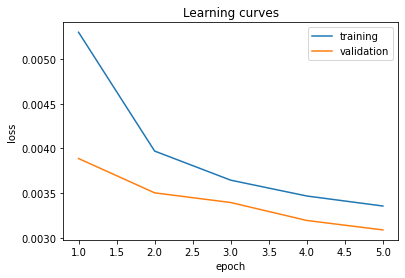

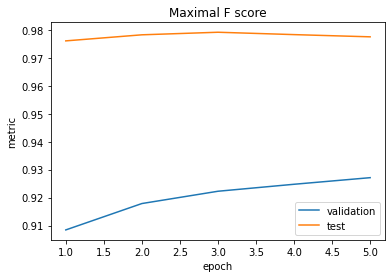

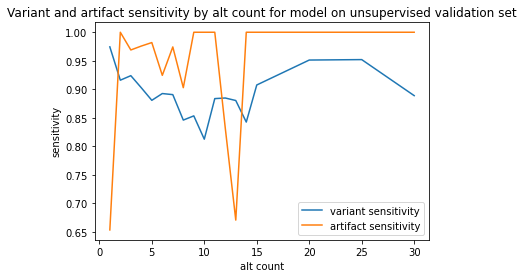

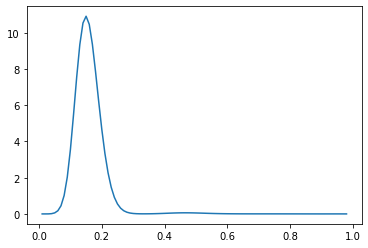

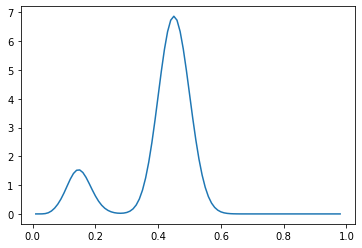

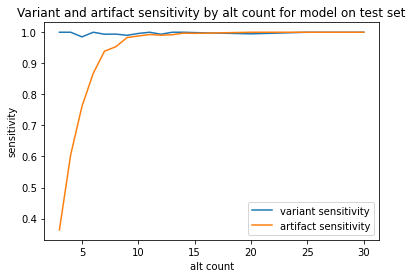

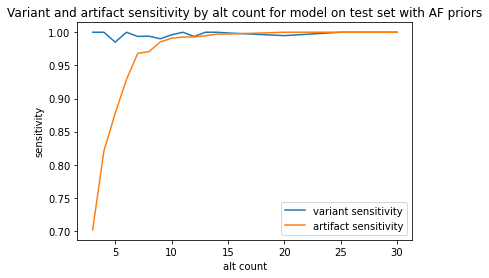

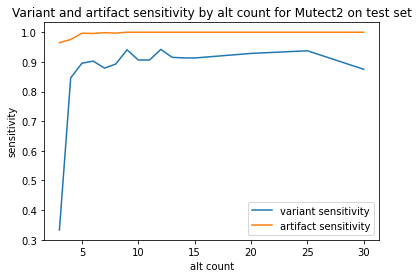

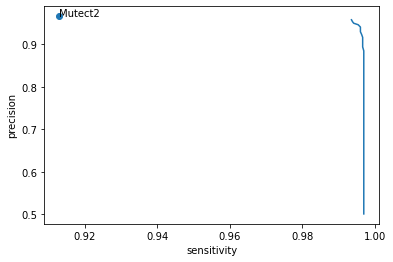

In [12]:
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 5)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_4_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_1_TEST, 50)